# Traffic Light Detection

## Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

C:\tensorflow\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\hchen\appdata\local\continuum\anaconda3\envs\carnd-term3-tl-detection\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\hchen\appdata\local\continuum\anaconda3\envs\carnd-term3-tl-detection\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\hchen\appdata\local\continuum\anaconda3\envs\carnd-term3-tl-detection\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\hchen\appdata\local\continuum\anaconda3\envs\carnd-term3-tl-detection\lib\site-pack

In [ ]:
LABEL_PATH = 'config/label_map.pbtxt'
SIM_MODEL_PATH = 'model_frozen_sim/frozen_inference_graph.pb'
REAL_MODEL_PATH = 'model_frozen_real/frozen_inference_graph.pb'
SIM_TEST_IMAGE_PATH = 'data/test_images/sim'
REAL_TEST_IMAGE_PATH = 'data/test_images/real'
IMAGE_SIZE = (12, 8)

In [6]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Red'}, 2: {'id': 2, 'name': 'Yellow'}, 3: {'id': 3, 'name': 'Green'}, 4: {'id': 4, 'name': 'off'}}


In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
from glob import glob

## Functions

In [9]:
def import_graph(model_path):
    detection_graph = tf.Graph()
    
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
    
      with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
    return detection_graph
        
    
def load_test_images(directory):
    print(os.path.join(directory, '*.jpg'))
    image_paths = glob(os.path.join(directory, '*.jpg'))
    print("Length of test images:", len(image_paths))
    return image_paths

In [10]:
def predict(detection_graph, image_paths):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in image_paths:
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                time0 = time.time()

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

                time1 = time.time()

                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                classes = np.squeeze(classes).astype(np.int32)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np, boxes, classes, scores,
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=6)

                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)
                plt.show()

                min_score_thresh = .50
                for i in range(boxes.shape[0]):
                    if scores is None or scores[i] > min_score_thresh:

                        class_name = category_index[classes[i]]['name']
                        print('{}'.format(class_name), scores[i])

                        fx =  0.97428
                        fy =  1.73205
                        perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                        perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                        # ymin, xmin, ymax, xmax = box
                        # depth_prime = (width_real * focal) / perceived_width
                        perceived_depth_x = ((.1 * fx) / perceived_width_x)
                        perceived_depth_y = ((.3 * fy) / perceived_width_y )

                        estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                        print("Distance (metres)", estimated_distance)
                        print("Time in milliseconds", (time1 - time0) * 1000, "\n")

## Detection: Simulator Test Pictures

data/test_images/sim\*.jpg
Length of test images: 12


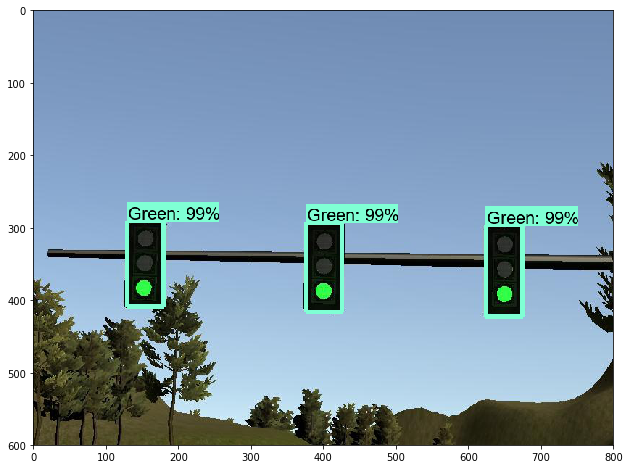

Green 0.9997788
Distance (metres) 0.0
Time in milliseconds 2279.010057449341 

Green 0.99973375
Distance (metres) 0.0
Time in milliseconds 2279.010057449341 

Green 0.9992306
Distance (metres) 0.0
Time in milliseconds 2279.010057449341 



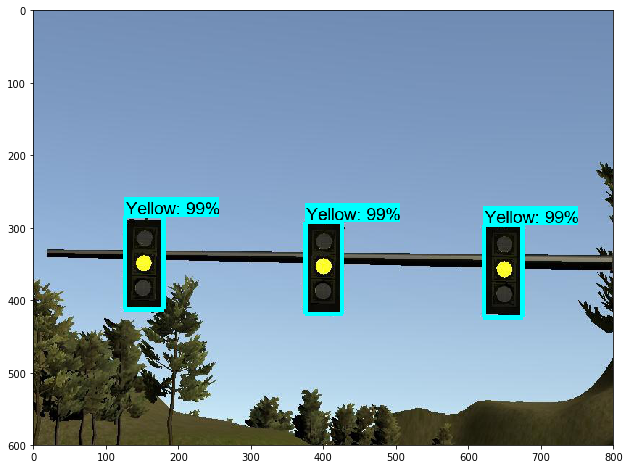

Yellow 0.9998311
Distance (metres) 0.0
Time in milliseconds 235.66770553588867 

Yellow 0.99976665
Distance (metres) 0.0
Time in milliseconds 235.66770553588867 

Yellow 0.9987078
Distance (metres) 0.0
Time in milliseconds 235.66770553588867 



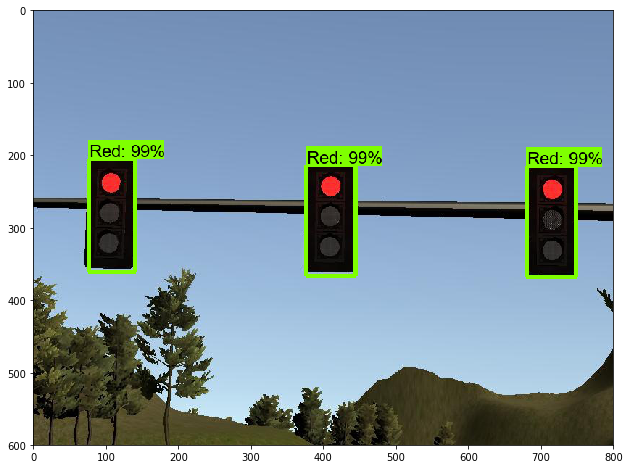

Red 0.99856156
Distance (metres) 0.0
Time in milliseconds 244.17424201965332 

Red 0.99659234
Distance (metres) 0.0
Time in milliseconds 244.17424201965332 

Red 0.9930051
Distance (metres) 0.0
Time in milliseconds 244.17424201965332 



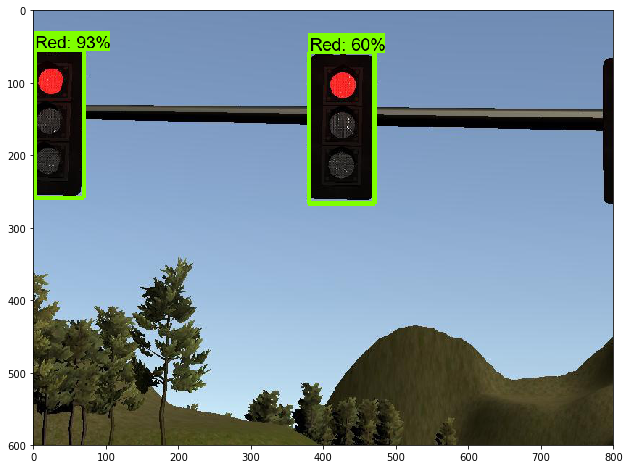

Red 0.9307587
Distance (metres) 0.0
Time in milliseconds 235.66675186157227 

Red 0.60050124
Distance (metres) 0.0
Time in milliseconds 235.66675186157227 



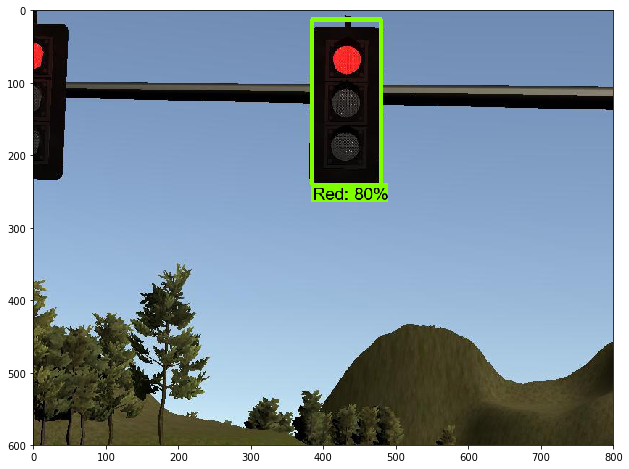

Red 0.80139714
Distance (metres) 0.0
Time in milliseconds 251.6794204711914 



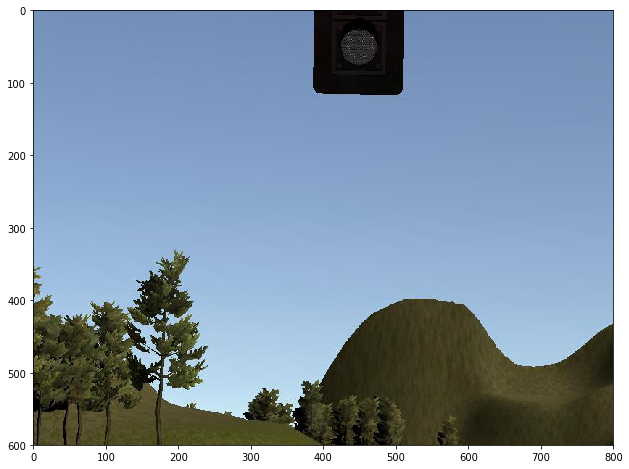

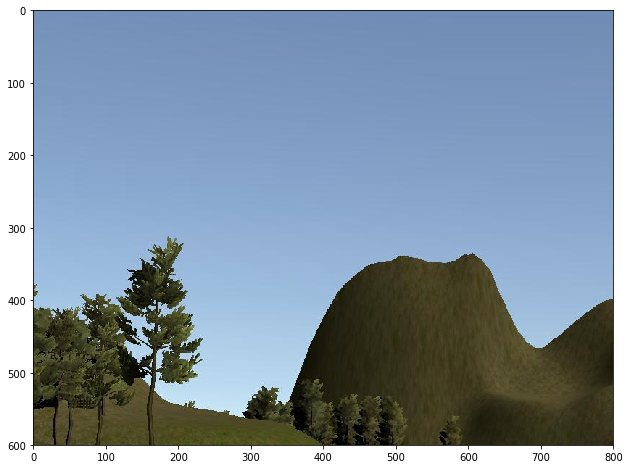

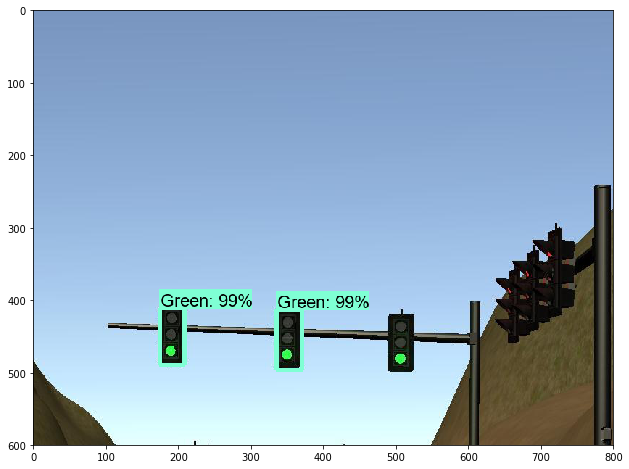

Green 0.9995541
Distance (metres) 0.0
Time in milliseconds 247.1761703491211 

Green 0.9969625
Distance (metres) 0.0
Time in milliseconds 247.1761703491211 



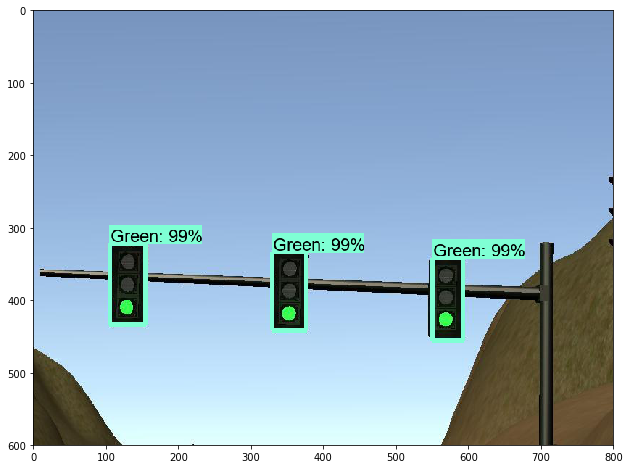

Green 0.9998293
Distance (metres) 0.0
Time in milliseconds 235.66699028015137 

Green 0.9995486
Distance (metres) 0.0
Time in milliseconds 235.66699028015137 

Green 0.9989723
Distance (metres) 0.0
Time in milliseconds 235.66699028015137 



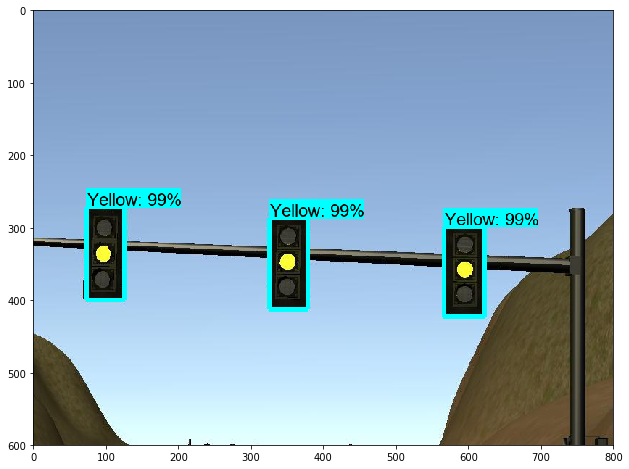

Yellow 0.9995617
Distance (metres) 0.0
Time in milliseconds 249.1776943206787 

Yellow 0.9976907
Distance (metres) 0.0
Time in milliseconds 249.1776943206787 

Yellow 0.9957573
Distance (metres) 0.0
Time in milliseconds 249.1776943206787 



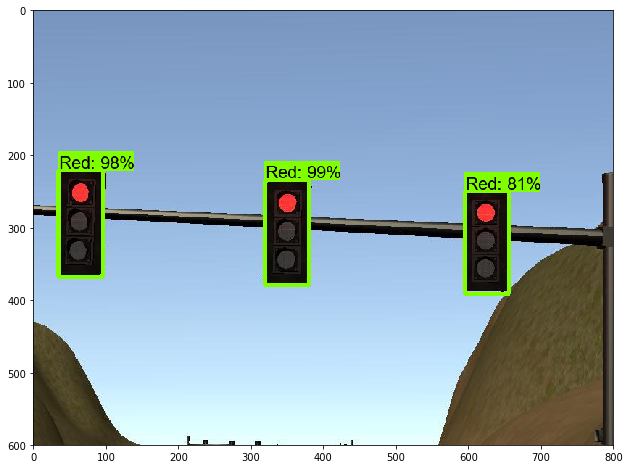

Red 0.9973859
Distance (metres) 0.0
Time in milliseconds 240.67091941833496 

Red 0.98768765
Distance (metres) 0.0
Time in milliseconds 240.67091941833496 

Red 0.8189243
Distance (metres) 0.0
Time in milliseconds 240.67091941833496 



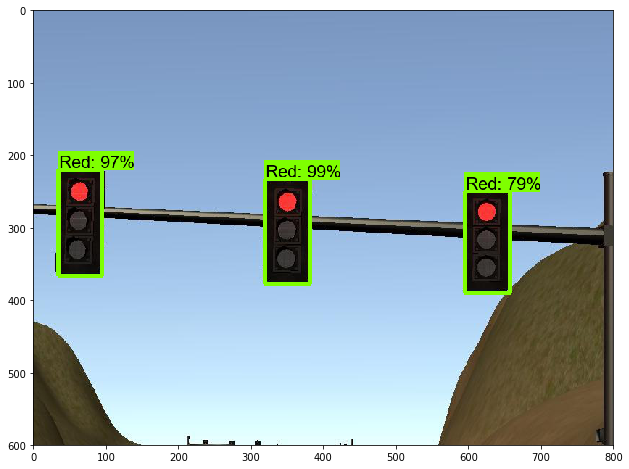

Red 0.9956079
Distance (metres) 0.0
Time in milliseconds 230.1640510559082 

Red 0.97172225
Distance (metres) 0.0
Time in milliseconds 230.1640510559082 

Red 0.79028445
Distance (metres) 0.0
Time in milliseconds 230.1640510559082 



In [14]:
detection_graph = import_graph(SIM_MODEL_PATH)
image_paths = load_test_images(SIM_TEST_IMAGE_PATH)
predict(detection_graph, image_paths)

## Detection: Real Test Pictures

data/test_images/real\*.jpg
Length of test images: 9


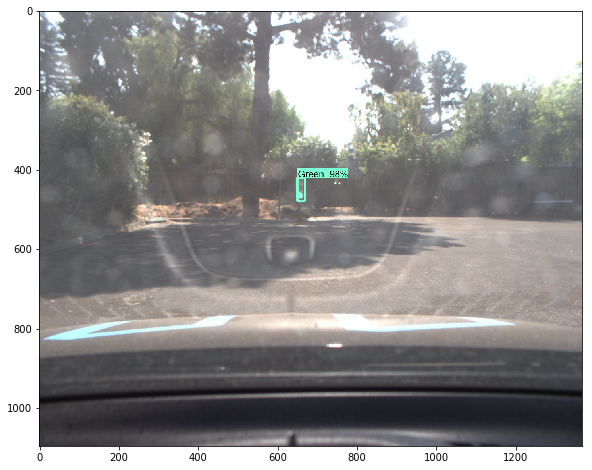

Green 0.98854685
Distance (metres) 0.0
Time in milliseconds 2229.482889175415 



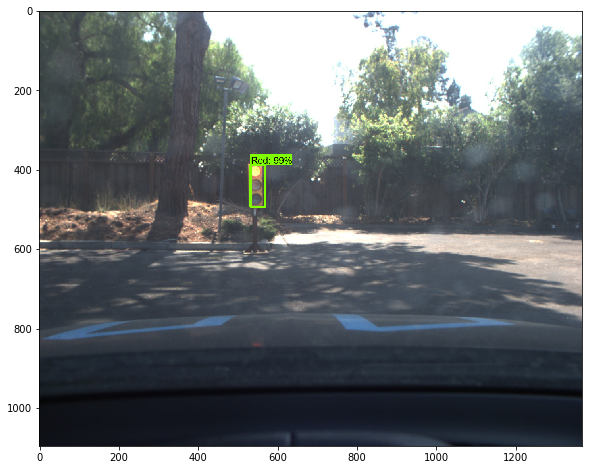

Red 0.9976267
Distance (metres) 0.0
Time in milliseconds 254.17804718017578 



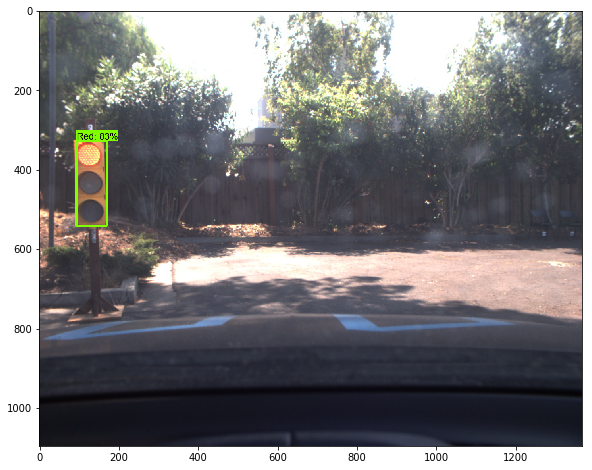

Red 0.83981425
Distance (metres) 0.0
Time in milliseconds 263.17548751831055 



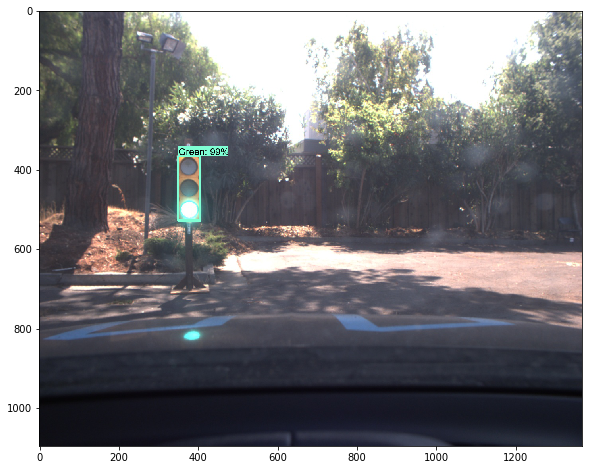

Green 0.99674124
Distance (metres) 0.0
Time in milliseconds 302.2148609161377 



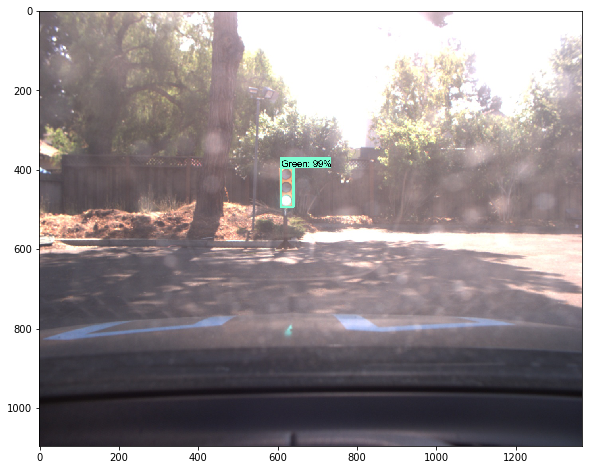

In [ ]:
detection_graph = import_graph(REAL_MODEL_PATH)
image_paths = load_test_images(REAL_TEST_IMAGE_PATH)
predict(detection_graph, image_paths)